# `BoXHED2.0` tutorial
`BoXHED2.0` (Pakbin et al. 2023) is a [software package](https://github.com/boxhed/boxhed2.0) for estimating hazard functions nonparametrically via gradient boosting. It is a major extension of `BoXHED1.0` (Wang et al. 2020).

This tutorial demonstrates how to apply `BoXHED2.0` to a synthetic dataset.

Please refer to Pakbin et al. (2023) for the basics of time-dependent survival data. The theoretical underpinnings for `BoXHED` is provided in Lee, Chen, and Ishwaran (2021).

### Suggested citations
- Pakbin, Wang, Mortazavi, Lee (2023): [BoXHED2.0: Scalable boosting of dynamic survival analysis](https://arxiv.org/abs/2103.12591) *Working paper*

- Lee, Chen, Ishwaran (2021): [Boosted nonparametric hazards with time-dependent covariates](https://projecteuclid.org/journals/annals-of-statistics/volume-49/issue-4/Boosted-nonparametric-hazards-with-time-dependent-covariates/10.1214/20-AOS2028.full) (*Annals of Statistics* 49:4:2101-2128)

- Wang, Pakbin, Mortazavi, Zhao, Lee (2020): [BoXHED: Boosted eXact Hazard Estimator with Dynamic covariates](https://proceedings.mlr.press/v119/wang20o.html) (*ICML* 9973–9982)


In [1]:
import os
import pandas as pd
from boxhed.boxhed import boxhed
from boxhed.model_selection import cv, best_param_1se_rule
from boxhed.utils import timer

In [2]:
DATA_ADDRESS = "./data/"    # directory containing the synthetic training and test data

## 1. Required format for training data
A `pandas` dataframe with the following columns:
* ID:      subject ID
* $t_{start}$: the start time of an epoch for the subject
* $t_{end}$:   the end time of the epoch
* $X_i$:       values of covariates between $t_{start}$ and $t_{end}$
* $\delta$:    equals 1 if an event (possibly recurring) occurred at $t_{end}$; 0 otherwise

Illustrative input:

    ID  t_start     t_end       X_0         ...     X_10        delta 
    1   0.0100      0.0747      0.2655              0.2059      1
    1   0.0747      0.1072      0.7829              0.4380      0
    1   0.1072      0.1526      0.7570              0.7789      1
    2   0.2066      0.2105      0.9618              0.0859      1
    2   0.2345      0.2716      0.3586              0.0242      0

* For each epoch (row) we must have $0 \le t_{start} < t_{end}$. Also, the beginning of one epoch cannot start earlier than the end of the previous one, i.e. $t_{end,i} \le t_{start,i+1}$.
* For covariates with missing values, `BoXHED2.0` implements tree splits of the form:

$$\text{Left daughter node: } \{x\le \text{split.point or $x$ is missing}\}; \qquad \text{Right daughter node: } \{x>\text{split.point}\}$$

or

$$\text{Left daughter node: } \{x\le \text{split.point}\}; \qquad \text{Right daughter node: } \{x>\text{split.point or $x$ is missing}\}$$

Alternatively, missing values may be manually imputed, e.g. by carrying forward the most recent value.

In [3]:
train_data = pd.read_csv(os.path.join(DATA_ADDRESS, 'training.csv'))

## 2. Evaluation data (optional)
A `pandas` dataframe, having the same form as the training data, used for evaluating a fitted `BoXHED2.0` instance using log-likelihood.

In [4]:
eval_data = pd.read_csv(os.path.join(DATA_ADDRESS, 'evaluation.csv'))

## 3. Test data points (optional)
A `pandas` dataframe where each row consists of a point $(t,x_0,x_1,\cdots)$ where we want to evaluate the estimated `BoXHED` hazard function $\hat\lambda(t,x_0,x_1,\cdots)$.

In [5]:
test_X = pd.read_csv(os.path.join(DATA_ADDRESS, 'testing.csv'))

## 4. Preprocessing the training data
`BoXHED2.0` applies a preprocessing trick to the training data to speed up training (see Section 3.3 of Pakbin et al.). **THE DATA ONLY NEEDS TO BE PREPROCESSED ONCE PER TRAINING SET**. `BoXHED2.0` does not use the original training data, just the outputs from the `boxhed.preprocess()` function.

#### Inputs for `boxhed.preprocess()`:
* `num_quantiles`: the number of candidate split points to try for time and for each non-categorical covariate.

The locations of the split points are based on the quantiles of the training data. The default value for `num_quantiles` is set to the maximum allowable of 256.
   
* `is_cat`: a list of the column indexes that contain categorical data. The categorical data must be one-hot encoded. For example, `is_cat`=[4,5,6] if a categorical variable with 3 factors is transformed into binary-valued columns 4,5,6.
* `split_vals`: To specify custom candidate split points for time and/or a subset of non-categorical covariates, use a dictionary to specify the values to split on (details below). Do not provide more than `num_quantiles` candidate splits for any one variable. Candidate split points for time/non-categorical covariates not specified in `split_vals` will be chosen in accordance to the `num_quantiles` option above.

For specifying candidate split points for time, the dictionary key should be "t", and the dictionary value should be a list (or a 1d `NumPy` array) containing candidate split points. For covariates, the key should match the column name in the dataset. Key values "ID", "t_start", "t_end", and "delta" are not allowed.
     
* `weighted`: if set to True, the locations of the candidate split points will be based on weighted quantiles (see Section 3.4 of Pakbin et al.).

* `nthreads`: number of CPU threads to use for preprocessing the data.

#### Output for `boxhed.preprocess()`:
* `X_post`: a dictionary containing the following components:
  * `ID`:            subject ID for each row in the processed data frames `X`, `w`, and `delta`.
  * `X`:             each row represents an epoch of the transformed data, and contains the values of the covariates as well as its start time.
  * `w`:             length of each epoch.    
  * `delta`:         equals one if an event occurred at the end of the epoch; zero otherwise.

In [6]:
train_info_dict = {}                          # Define the output dictionary
boxhed_ = boxhed()                            # Create an instance of BoXHED
prep_timer = timer()                          # Initialize timer

X_post = boxhed_.preprocess(data = train_data, 
                            #is_cat       = [],
                            #split_vals   = {"t": [0.2, 0.4, 0.6, 0.8], "X_2": [0, 0.4, 0.9]},
                            num_quantiles = 256, 
                            weighted      = False, 
                            nthread       = -1) # number of CPU threads to use. Set to -1 to use all available threads

train_info_dict["prep_time"] = prep_timer.get_dur()  # time taken to preprocess the training data

## 5. Tuning hyperparameters by $K$-fold cross-validation
### THIS IS THE MOST TIME CONSUMING STEP! If you know which hyperparameters to use, skip to step 6
Like other gradient boosting algorithms, the main `BoXHED` hyperparameters that need to be tuned are
- the depth of each boosted tree `max_depth`; and
- the number of trees `n_estimators`.
    
We use $K$-fold cross-validation and the one-standard-error rule to determine the best hyperparameter combination to use.

We proceed in two steps. First, for each {`max_depth`, `n_estimators`} combination specified by the user, the `cv()` function is used to obtain the $K$-fold mean and standard error for the associated log-likelihood value. The folds are split by subject ID. For this example, the output `cv_rslts` from `cv()` can be expressed in the tabular form (standard errors in parentheses):
         
          n_estimators     50              100              150            200             250             300
    max_depth 
      1                    -518.84(5.72)   -500.75(5.05)   -496.83(4.86)   -495.81(4.72)   -495.93(4.77)   -495.97(4.73)
      2                    -499.32(4.70)   -498.62(4.91)   -500.91(4.99)   -502.83(5.24)   -505.10(5.49)   -507.48(5.38)
      3                    -500.69(4.73)   -508.07(5.00)   -513.77(5.04)   -520.41(4.91)   -526.88(4.73)   -533.33(4.50)
      4                    -507.09(5.73)   -518.29(6.15)   -531.18(5.92)   -545.01(6.03)   -555.32(5.69)   -569.18(6.48) 
      5                    -516.20(6.37)   -533.55(5.89)   -555.09(6.06)   -572.67(7.07)   -593.68(7.00)   -614.24(7.51) 

#### Inputs for `cv()`:
* `param_grid`: the set of hyperparameters to try (see code below for example).

The example below tries trees of depth up to 5 ($2^5$ leaf nodes) and no more than 300 trees. If the hyperparameter combination with the highest mean log-likelihood value was actually at `max_depth`=5, then you should try larger `max_depth` values in `param_grid`. Similarly, if said hyperparameter combination used 300 trees, you should try larger `n_estimators` values in `param_grid`.

Five different 300-tree ensembles are grown in this example, with one ensemble for each value of `max_depth`. The first 50 trees from the 300-tree ensemble are used to perform $K$-fold cross-validation for `n_estimators=50`, and the first 100 trees are used for `n_estimators=100` etc.

* `X_post`: the processed data output from `boxhed_.preprocess()`.
* `num_folds`: the number $K$ in $K$-fold cross-validation.
* `ID`: does not have to be the same as `X_post['ID']`. This `ID` variable is used to divide the processed rows into $K$ folds, with each fold containing the same number of unique `ID` values. All processed rows with the same `ID` value will be assigned to the same fold (see example below). 
* `seed`: the number $K$ in $K$-fold cross-validation.
* `gpu_list`: the list of GPU IDs to use for training. Set `gpu_list`=[-1] to use CPUs.
* `nthreads`: if training with CPUs, this is the number of threads to use. Default is -1 (use all available threads).
* `models_per_gpu`: number of instances to train on each GPU.

For example, performing 10-fold cross-validation on 5 different values of `max_depth` requires training 10$\times$5=50 instances in total. If using GPUs, setting `models_per_gpu`=6 would mean that each GPU will train at most 6 instances at a time, requiring a total of $\lceil$50/6$\rceil$=9 GPU batches. The right value of `models_per_gpu` to use will require some exploration, as it depends on the problem size and GPU memory.

#### Output for `cv()`:
* `cv_rslts`: the $K$-fold mean and standard error of the log-likelihood value for each hyperparameter combination.       

In [7]:
#Just an example to illustrate how the ID variable can be used.
#Suppose we want the processed rows with subject IDs from 1 to 100 to be assigned to
#the same fold during K-fold cross-validation. The following will achieve this

ID = X_post['ID'].values

#comment out the lines below if you do not want to group the subjects together
ID[ID<100] = 100
print (ID)

[ 100.  100.  100. ... 5000. 5000. 5000.]


In [8]:
num_folds = 5

#The set of hyperparameters to cross-validate on (more trees and/or deeper trees may be needed for other datasets)
param_grid = {
        'max_depth':    [1, 2, 3, 4, 5],                 #a tree of depth k has 2^k leaf nodes
        'n_estimators': [50, 100, 150, 200, 250, 300],   #number of trees in the boosted ensemble
        'eta':          [0.1]                            #stepsize shrinkage, usually held fixed at a small number
    }

gpu_list = [-1]   # if training with CPU cores
#gpu_list = [0]   # if training with the first GPU
#gpu_list = [0,1] # if training with the first 2 GPUs etc.

  
cv_timer = timer()
cv_rslts = cv(param_grid, 
              X_post,
              num_folds,
              gpu_list,
              seed    = 6, 
              ID      = ID,
              nthread = -1,         #-1 means use all available CPU threads if training with CPU 
              models_per_gpu = 15)  #the optimal number to use for a specific problem will require some exploration

train_info_dict["CV_time"] = cv_timer.get_dur() #time taken to perform K-fold cross-validation


#print the K-fold means and standard errors of the log-likelihood values
import numpy as np
nrow, ncol = len(param_grid['max_depth']), len(param_grid['n_estimators'])
print('K-fold mean log-likelihood:')
print( np.around( cv_rslts['score_mean'].reshape(nrow, ncol), 2) )
print('K-fold standard error:')
print( np.around( cv_rslts['score_ste'].reshape(nrow, ncol), 2) )

batched cross validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.12s/it]

K-fold mean log-likelihood:
[[-518.84 -500.75 -496.83 -495.81 -495.93 -495.97]
 [-499.32 -498.62 -500.91 -502.83 -505.1  -507.48]
 [-500.69 -508.07 -513.77 -520.41 -526.88 -533.33]
 [-507.09 -518.29 -531.18 -545.01 -555.32 -569.18]
 [-516.2  -533.55 -555.09 -572.67 -593.68 -614.24]]
K-fold standard error:
[[5.72 5.05 4.86 4.72 4.77 4.73]
 [4.7  4.91 4.99 5.24 5.49 5.38]
 [4.73 5.   5.04 4.91 4.73 4.5 ]
 [5.73 6.15 5.92 6.03 5.69 6.48]
 [6.37 5.89 6.06 7.07 7.   7.51]]


From the tabular form of `cv_rslts` above, the mean log-likelihood is maximized at {`max_depth`=1, `n_estimators`=200} with value $-495.81$. However, the *one-standard-error rule* ($\S$7.10 in 'Elements of Statistical Learning' by Hastie et al. (2009)) suggests choosing the 'simplest model' whose mean log-likelihood is no less than 1 standard error from the maximum. In other words, choose the simplest model whose mean log-likelihood is no less than $-495.81-4.72 = -500.53$. The hyperparameters with mean log-likelihood larger than this are:

          n_estimators     50              100             150             200             250             300
    max_depth 
      1                                                    -496.83         -495.81         -495.93         -495.97
      2                    -499.32         -498.62
      3
      4               
      5                 

There is no generally accepted way to compare the complexities of these choices against one another. One heuristic is to define the complexity of a hyperparameter combination as

$$\log_2\left( \text{n\_estimators}\times 2^\text{max\_depth} \right) = \log_2( \text{n\_estimators}) + \text{max\_depth},$$

which is $\log_2$(total number of leaf nodes in tree ensemble). Under this criterion, {`max_depth`=2, `n_estimators`=50} has the lowest complexity, and is hence the most parsimonious choice. However, if we only consider hyperparameters with `max_depth`$\le$1 and `n_estimators`$\le$200, then {`max_depth`=1, `n_estimators`=150} is the most parsimonious.

In the second step of hyperparameter tuning below, the user supplies a custom `model_complexity()` function. The `best_param_1se_rule()` uses this to implement the one-standard-error rule for choosing the hyperparameter combination to use for fitting `BoXHED2.0`.

#### Inputs for `best_param_1se_rule()`:
* `cv_rslts`: the output from the $K$-fold cross-validation step above.
* `model_complexity`: user-defined function for measuring the complexity of a particular hyperparameter combination.
* `bounded_search`: In this example, the hyperparameter combination maximizing the mean log-likelihood is {`max_depth`=1, `n_estimators`=200}. If this option is set to `True` (the default), then any combination with `max_depth`>1 or `n_estimators`>200 trees will be discarded.

#### Outputs for `best_param_1se_rule()`:
* `best_params`: the hyperparameter combination for the most parsimonious model.
* `params_within_1se`: the list of all hyperparameter combinations whose mean log-likelihood is within 1 standard error of that of the best performing combination.

In [9]:
#user-defined measure of model complexity
def model_complexity(max_depth, n_estimators):
    from math import log2
    return log2(n_estimators) + max_depth


cv_timer = timer()
best_params, params_within_1se = best_param_1se_rule(cv_rslts,
                                                     model_complexity,
                                                     bounded_search=True)   #default is True

train_info_dict["CV_time"] += cv_timer.get_dur()   #update to total time taken to tune hyperparameters

print (best_params) # Print chosen hyperparameters

{'max_depth': 1, 'n_estimators': 150}


## 6. Fitting `BoXHED2.0` to training data
Fit the hazard function using the cross-validated hyperparameters chosen above. Alternatively, users may manually specify the desired hyperparameters to use for fitting.

In [10]:
use_manual_parms = False   #set to True if you want to manually specify the hyperparameters
manual_params = {'max_depth':1, 'n_estimators':150, 'eta':0.1}


if use_manual_parms:
    params = manual_params
else:
    params = best_params


params['gpu_id'] = -1            # Use CPU cores to fit BoXHED
#params['gpu_id'] = 0            # Use the first GPU device to fit BoXHED
params['nthread'] = -1           # If fitting with CPU, the number of threads to use (-1 means use all available threads) 
train_info_dict.update(params)
boxhed_.set_params(**params)


# Fit BoXHED to the training data
fit_timer = timer()
boxhed_.fit(X_post['X'], X_post['delta'], X_post['w'])
train_info_dict["fit_time"] = fit_timer.get_dur()

In [11]:
print (train_info_dict)                         # Timings of the different training components
print ("feature importances:", boxhed_.VarImps) # Variables importances
print (boxhed_.time_splits)                     # The set of time values where tree splits are made 

{'prep_time': 0.197, 'CV_time': 55.938, 'max_depth': 1, 'n_estimators': 150, 'gpu_id': -1, 'nthread': -1, 'fit_time': 1.839}
feature importances: {'X_0': 1971.2105061100006, 'time': 1558.9728342899996, 'X_4': 21.197394600000003, 'X_9': 9.797206169999999, 'X_1': 6.96407747, 'X_10': 6.74315118, 'X_6': 2.85510993, 'X_7': 5.40960407}
[0.02808942 0.03664268 0.04399679 0.05080229 0.07195223 0.08448574
 0.10632804 0.11365116 0.14457831 0.15541401 0.19221287 0.20235221
 0.21580724 0.23802075 0.32940677 0.36373076 0.4240337  0.69717562
 0.70240098 0.72262114 0.82380444 0.83513868 0.84786463 0.89849269
 0.93779886 0.97168624]


The fitted `BoXHED2.0` instance can be inspected by printing it:

In [12]:
print (boxhed_)

a BoXHED estimator instance
    max_depth:    1
    n_estimators: 150
    eta:          0.1



You can also use the fitted model to calculate the log-likelihood for a dataset that is not preprocessed:

In [13]:
boxhed_.loglik(eval_data)

-251.55979526245358

## 7. Plot the estimated hazard function
Use the fitted model to estimate the hazard value $\hat\lambda(t,x_0,x_1,\cdots)$ for each row of the test data, which consists of a point $(t,x_0,x_1,\cdots)$.

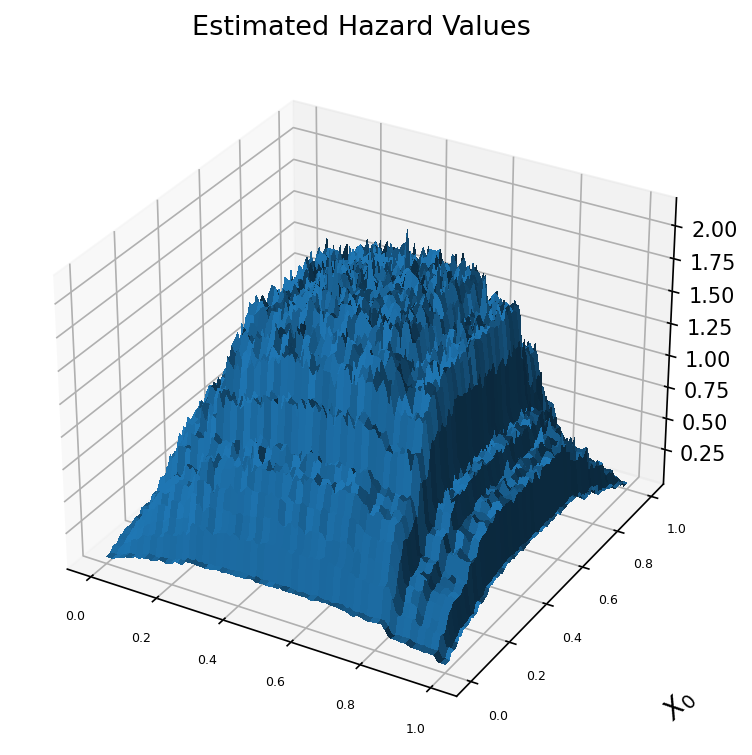

In [14]:
# Estimate the value of the hazard function for each row of the test set
haz_vals = boxhed_.hazard(test_X)

import math
import matplotlib.pyplot as plt

figsize  = (6,6)
dpi      = 150
fontsize = 13

fig  = plt.figure(figsize=figsize, dpi=dpi)
ax   = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(*[arr.reshape(*([int(math.sqrt(len(haz_vals)))]*2)) for arr in [test_X['t'].values, test_X['X_0'].values, haz_vals]],
                    linewidth=0, antialiased=False)

plt.title("Estimated Hazard Values", fontsize=fontsize)
plt.ylabel(r"$X_0$", fontsize=fontsize, rotation=0, labelpad=30)
plt.xlabel("time",   fontsize=fontsize, rotation=0, labelpad=30)

plt.xticks(fontsize= fontsize-7)
plt.yticks(fontsize= fontsize-7)

plt.show()

## 8. Plotting the conditional survivor curve $S(t|x)=P(T>t|x)$ when $x$ is time-static
As explained in $\S$1 of Pakbin et al., the survivor curve is not meaningful when the covariates $x_t$ change over time. However, if $x=(x_0,x_1,\cdots)$ is time-static, $S(t|x)$ can be estimated using `BoXHED2.0`.

In the example below we demonstrate how to plot $\hat S(t|x)$ for $0\le t <1$, where $x$ are the values of the covariates for one of the subjects in the test data. For the sake of this example, assume that $x$ is fixed over time.


In [15]:
# Create a dataframe df_surv where each row (t, x_0, x_1, ...) is a point we wish
# to estimate the value of the survivor curve at
t           = [t/100 for t in range(0, 100)]
df_surv      = pd.concat([test_X.loc[2000].to_frame().T]*len(t)).reset_index(drop=True)
df_surv['t'] = t
print (df_surv.head())

      t      X_0       X_1       X_2       X_3       X_4      X_5       X_6  \
0  0.00  0.20202  0.764793  0.911585  0.194879  0.452047  0.92748  0.717122   
1  0.01  0.20202  0.764793  0.911585  0.194879  0.452047  0.92748  0.717122   
2  0.02  0.20202  0.764793  0.911585  0.194879  0.452047  0.92748  0.717122   
3  0.03  0.20202  0.764793  0.911585  0.194879  0.452047  0.92748  0.717122   
4  0.04  0.20202  0.764793  0.911585  0.194879  0.452047  0.92748  0.717122   

        X_7       X_8       X_9      X_10  
0  0.493491  0.867334  0.899182  0.128217  
1  0.493491  0.867334  0.899182  0.128217  
2  0.493491  0.867334  0.899182  0.128217  
3  0.493491  0.867334  0.899182  0.128217  
4  0.493491  0.867334  0.899182  0.128217  


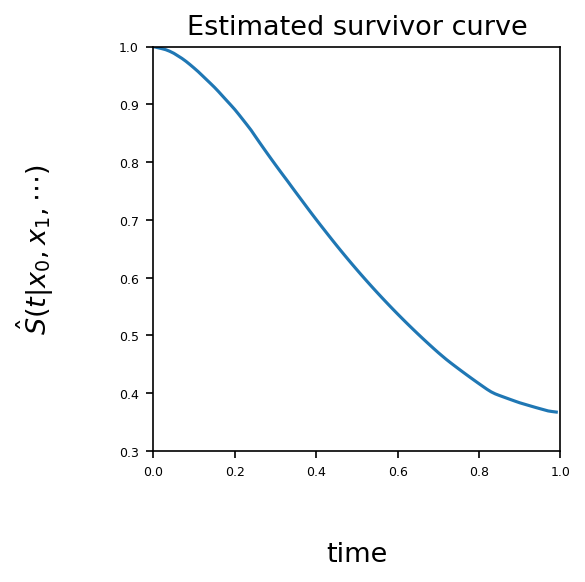

In [16]:
# Estimate the value the survivor curve for each row of df_surv
surv_vals = boxhed_.survivor(df_surv)

figsize  = (3.5,3.5)
dpi      = 150
fontsize = 13

fig  = plt.figure(figsize=figsize, dpi=dpi)
ax   = fig.add_subplot()
ax.plot (t, surv_vals)

plt.title("Estimated survivor curve", fontsize=fontsize)
plt.ylabel(r"$\hat S(t|x_0,x_1,\cdots)$", fontsize=fontsize, rotation=90, labelpad=30)
plt.xlabel("time",   fontsize=fontsize, rotation=0, labelpad=30)

plt.xticks(fontsize= fontsize-7)
plt.yticks(fontsize= fontsize-7)

plt.xlim([0, 1])
plt.ylim([0.3, 1])

plt.show()

## 9. Saving and loading the fitted `BoXHED2.0` estimator
Use `dump_model()` to save the fitted `BoXHED2.0` instance to disk, and use `load_model()` to retrieve it.

In [17]:
boxhed_.dump_model("./boxhed.pkl")

In [18]:
boxhed_2 = boxhed() #create a new BoXHED instance to load the saved estimator
boxhed_2.load_model("./boxhed.pkl") # after running this line, boxhed_2 is equivalent to boxhed_ fitted above

## 10. SHAP for `BoXHED2.0`
The pre-compiled `BoXHED2.0` packages come integrated with [SHAP](https://shap.readthedocs.io/en/latest/) (Python package `shap` version 0.41.0) in order to provide local explanations for the estimated log-hazard values in terms of the covariates and time.

In [19]:
import boxhed_shap
boxhed_shap.initjs()  #needed for creating visualizations

explainer = boxhed_shap.TreeExplainer(boxhed_.boxhed_) #define the TreeExplainer object

Calculate the log-hazard SHAP values at the points given by each row of `test_X`.
* The `test_X` dataframe needs to be converted into a `DMatrix` object for the `TreeExplainer` object. `DMatrix` is a data type used internally by the `XGBoost` library, and also by `BoXHED2.0`.

In [20]:
from boxhed_kernel import DMatrix

shap_X = test_X.rename(columns={'t':'time'}) #rename column 't' as 'time' in order to match the data columns in BoXHED2.0
shap_values = explainer.shap_values(shap_X)

Each row of `shap_values` contains the SHAP values for the corresponding row in `test_X`:

In [21]:
print (shap_values)

[[-1.8872765e+00 -1.9835367e+00 -2.5708552e-02 ...  0.0000000e+00
   3.8532289e-03  2.3047817e-03]
 [-1.8872765e+00 -1.9835367e+00  3.2798047e-03 ...  0.0000000e+00
  -9.4455685e-03  2.3047817e-03]
 [-1.8872765e+00 -1.9835367e+00 -2.5708552e-02 ...  0.0000000e+00
   3.8532289e-03  2.3047817e-03]
 ...
 [-1.5049142e+00 -2.5628231e+00  3.2798047e-03 ...  0.0000000e+00
   3.8532289e-03  2.3047817e-03]
 [-1.5049142e+00 -2.5628231e+00  3.2798047e-03 ...  0.0000000e+00
   3.8532289e-03  2.3047817e-03]
 [-1.5049142e+00 -2.5628231e+00  3.2798047e-03 ...  0.0000000e+00
   3.8532289e-03  2.3047817e-03]]


### Global summary plot for SHAP
A `beeswarm` plot provides a global summary of how time and the covariates influence the log-hazard values estimated by `BoXHED2.0`.

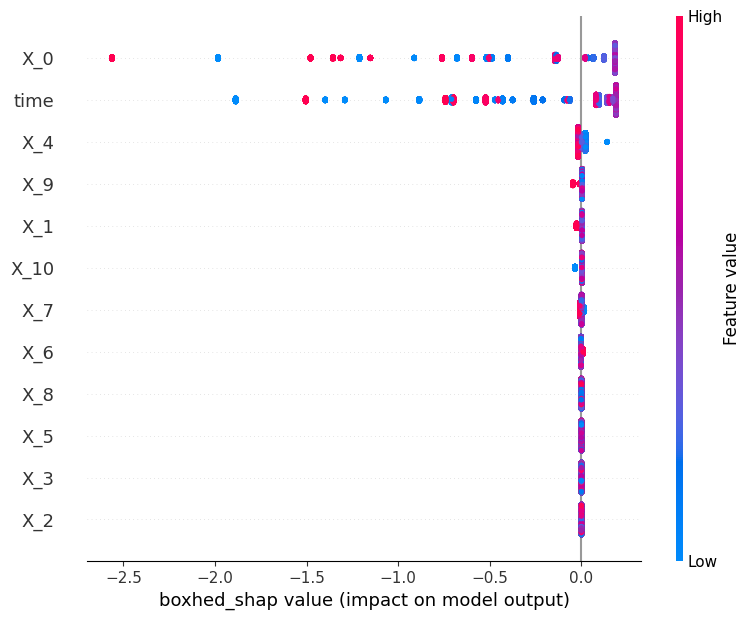

In [22]:
boxhed_shap.summary_plot(shap_values, shap_X)

### Local SHAP plots for a specific estimated log-hazard value
Suppose we wish to visualize the breakdown of the forces driving the estimated log-hazard value for the 1,256$^{th}$ row of `test_X`. First, let us look at the associated SHAP values:

In [23]:
row = 1256
shap_point = shap_values[row,:]
shap_point

array([ 0.18992297, -0.4879497 ,  0.0032798 ,  0.        ,  0.        ,
        0.02208973,  0.        , -0.00184674, -0.00817097,  0.        ,
        0.00385323,  0.00230478], dtype=float32)

One way to graph these SHAP values is via a `waterfall_plot`:

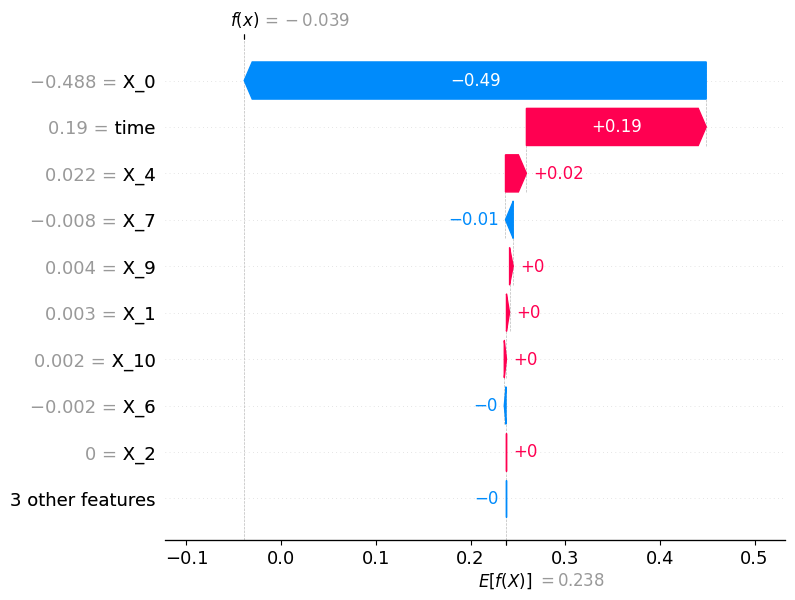

In [24]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

boxhed_shap.waterfall_plot(AttrDict({
    "base_values"   : explainer.expected_value,
    "values"        : shap_point, #explainer.shap_values(shap_X)[row,:],
    "feature_names" : shap_X.columns,
    "data"          : shap_point,
    "display_data"  : None}))    

Another approach is to use a `force_plot`:

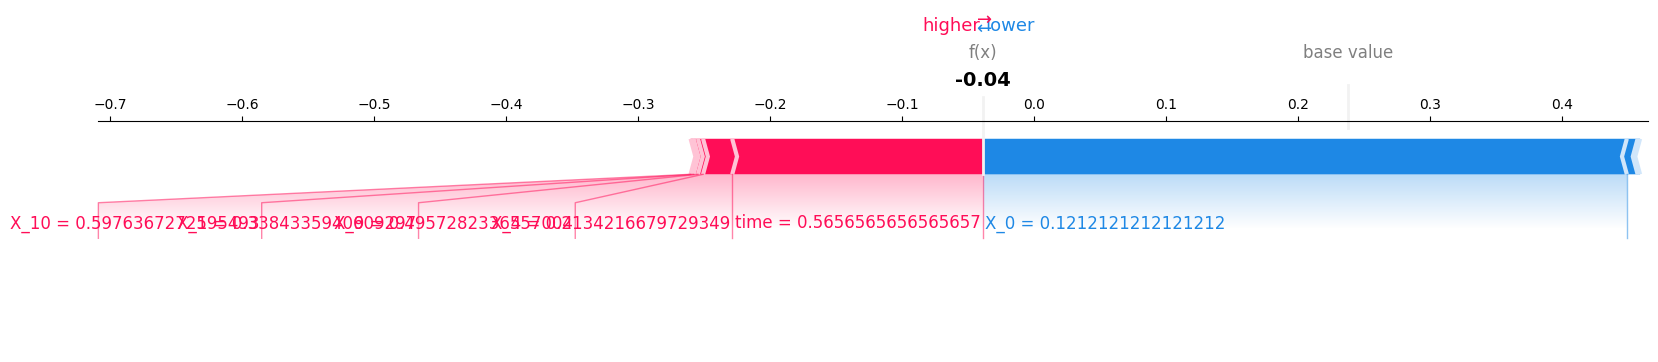

In [25]:
boxhed_shap.force_plot(explainer.expected_value, shap_point, shap_X.iloc[row,:], matplotlib=True)